# Step 2: MLP with HOG Features
This notebook performs digit classification on MNIST using HOG features and MLP models.


## 1. Load and preprocess MNIST data

In [1]:

from tensorflow.keras.datasets import mnist
import numpy as np
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Load MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize images
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


## 2. Extract HOG features

In [2]:

def extract_hog_features(images, pixels_per_cell, orientations=9):
    hog_features = [hog(img, orientations=orientations,
                        pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                        cells_per_block=(2, 2), block_norm='L2-Hys') for img in images]
    return np.array(hog_features)

# Extract for both pix_per_cell values
hog_features_4_train = extract_hog_features(x_train, 4)
hog_features_4_test = extract_hog_features(x_test, 4)

hog_features_7_train = extract_hog_features(x_train, 7)
hog_features_7_test = extract_hog_features(x_test, 7)

# Standardize
from sklearn.preprocessing import StandardScaler
scaler_4 = StandardScaler().fit(hog_features_4_train)
hog_features_4_train = scaler_4.transform(hog_features_4_train)
hog_features_4_test = scaler_4.transform(hog_features_4_test)

scaler_7 = StandardScaler().fit(hog_features_7_train)
hog_features_7_train = scaler_7.transform(hog_features_7_train)
hog_features_7_test = scaler_7.transform(hog_features_7_test)

# One-hot encode labels
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)


## 3. Build and train MLP models

In [3]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

def build_and_train_mlp(x_train, y_train, x_val, y_val, hidden_units, epochs=10):
    model = Sequential()
    model.add(Dense(hidden_units, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                        epochs=epochs, batch_size=128, verbose=0)
    return model, history


In [4]:

# Train models for both HOG variants
histories = {}

for pix_per_cell, xtr, xte in [(4, hog_features_4_train, hog_features_4_test), (7, hog_features_7_train, hog_features_7_test)]:
    for units in [128, 256, 512]:
        print(f"Training MLP with HOG {pix_per_cell} and {units} units...")
        model, history = build_and_train_mlp(xtr, y_train_cat, xte, y_test_cat, units)
        histories[(pix_per_cell, units)] = (model, history)


Training MLP with HOG 4 and 128 units...


C:\Users\natha\anaconda3\envs\ARN\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training MLP with HOG 4 and 256 units...
Training MLP with HOG 4 and 512 units...
Training MLP with HOG 7 and 128 units...
Training MLP with HOG 7 and 256 units...
Training MLP with HOG 7 and 512 units...


## 4. Plot validation accuracy

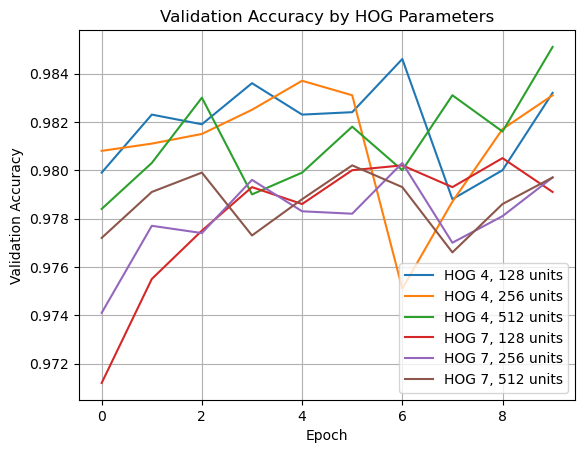

In [5]:

for (pix_per_cell, units), (_, history) in histories.items():
    plt.plot(history.history['val_accuracy'], label=f'HOG {pix_per_cell}, {units} units')

plt.title('Validation Accuracy by HOG Parameters')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


## 5. Evaluate best model

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step


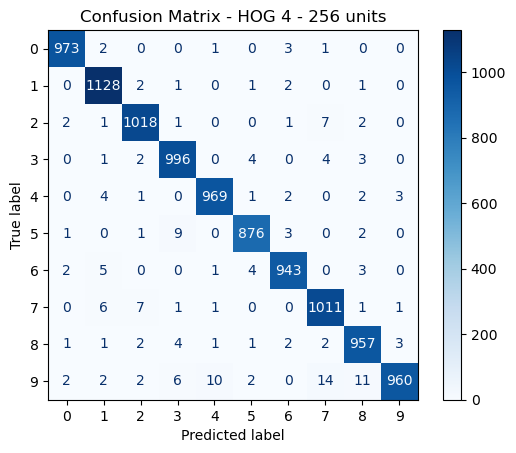

In [6]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Choose best performing configuration (e.g., HOG 4 with 256 units)
best_model = histories[(4, 256)][0]
y_pred = best_model.predict(hog_features_4_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(cm, display_labels=range(10))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - HOG 4 - 256 units")
plt.show()
